# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

**Ans**:

The task involves analyzing a structured dataset of 426K used cars to identify key factors influencing their prices.

This requires performing **exploratory data analysis (EDA)** to understand feature distributions, correlations, and potential outliers.

The problem can be framed as a **supervised regression task**, where the target variable is the car’s price, and independent variables include attributes such as make, model, year, mileage, fuel type, condition etc.

Feature engineering, data preprocessing, and predictive modeling techniques (e.g., linear regression, decision trees, or machine learning models) will be applied to determine the most significant predictors of used car prices.

The results will be translated into actionable insights for the dealership.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category-encoders
!pip install thefuzz
!pip install umap-learn
!pip install sentence-transformers

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import category_encoders as ce
from thefuzz import process
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split

In [40]:
vehicles = pd.read_csv("/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/vehicles.csv")

In [41]:
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [42]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**1. Unwanted columns**

**id** and **VIN** number can be dropped, this would not have any impacts on model creation.

**size** column has 71% of its values missing. We can drop this column.

**2. Missing values in percentage for each column**


In [43]:
missing_percentage = (vehicles.isnull().sum() / len(vehicles)) * 100
missing_percentage = missing_percentage.map(lambda x: f"{x:.2f}%")
print(missing_percentage)

id               0.00%
region           0.00%
price            0.00%
year             0.28%
manufacturer     4.13%
model            1.24%
condition       40.79%
cylinders       41.62%
fuel             0.71%
odometer         1.03%
title_status     1.93%
transmission     0.60%
VIN             37.73%
drive           30.59%
size            71.77%
type            21.75%
paint_color     30.50%
state            0.00%
dtype: object


**Major Concern**: condition, cylinders, and drive have over 30% missing values, which could impact modeling.

**size** column can be dropped as it has 71% of it data missing.

**3. Finding outliers**

In [44]:
print(vehicles.describe().applymap(lambda x: f"{x:.2f}"))

                  id          price       year     odometer
count      426880.00      426880.00  425675.00    422480.00
mean   7311486634.22       75199.03    2011.24     98043.33
std       4473170.41    12182282.17       9.45    213881.50
min    7207408119.00           0.00    1900.00         0.00
25%    7308143339.25        5900.00    2008.00     37704.00
50%    7312620821.00       13950.00    2013.00     85548.00
75%    7315253543.50       26485.75    2017.00    133542.50
max    7317101084.00  3736928711.00    2022.00  10000000.00


<ipython-input-44-cc0714585b93>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(vehicles.describe().applymap(lambda x: f"{x:.2f}"))


**price**, **year** and **odometer** has outliers.

**price** : Minimum price is 0, maximum price is given as 3736928711.00. This is a potential data issue

**year** : Minimum year is given as 1900, this looks like an outlier.

**odometer** : Minimum is given as 0, but maximum is 10 million. Its a potential data issue.








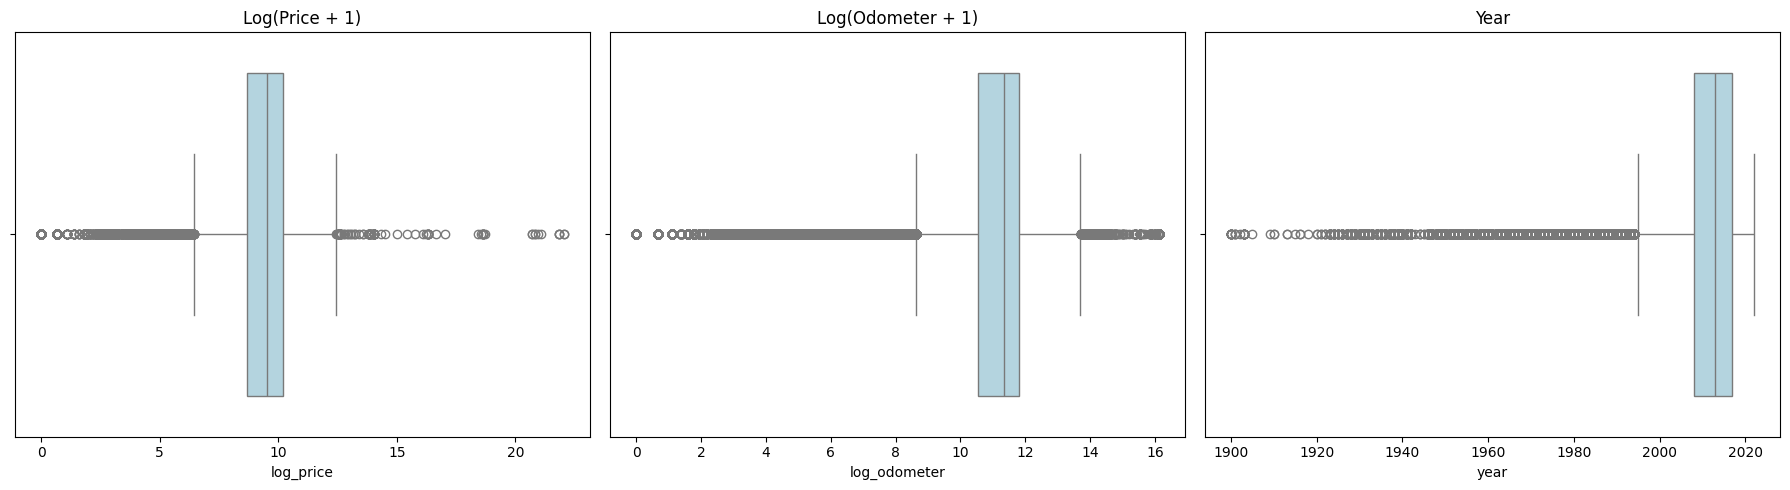

In [45]:
df = vehicles.convert_dtypes()

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already prepared and contains the log-transformed columns

# Set up the matplotlib figure with 1 row and 3 columns
plt.figure(figsize=(18, 5))

df['log_price'] = np.log1p(df['price'])  # Apply log transformation
df['log_odometer'] = np.log1p(df['odometer'])  # Apply log transformation

# Plot for 'log_price'
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.boxplot(x=df['log_price'], color="lightblue")
plt.title("Log(Price + 1)")

# Plot for 'log_odometer'
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.boxplot(x=df['log_odometer'], color="lightblue")
plt.title("Log(Odometer + 1)")

# Plot for 'log_year'
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.boxplot(x=df['year'], color="lightblue")
plt.title("Year")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

IQR For price, odometer and year

In [46]:
df = vehicles.convert_dtypes()

Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 99.9)

# Compute IQR
IQR = Q3 - Q1

# Compute Lower and Upper Bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display results
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Q1 (25th percentile): 5900.0
Q3 (75th percentile): 120000.0
IQR: 114100.0
Lower Bound: -165250.0
Upper Bound: 291150.0


**4. Textual data at a glance**

In [47]:
vehicles_modified = vehicles.convert_dtypes()
vehicles_modified.describe(include = ['string'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


Looks like we have lots of textual data with **non-standard texts**, **categories** and **ordinals**.

**Categorical** columns with higher number of categories can be transformed using **James-Stein** encoder. Those with lesser number of categories, we can use **OneHotEncoder** or **get_dummies**.

**Ordinal** columns such as condition can be transformed using **OrdinalEncoder**.

For **non-standard texts**, we need to startdardize by converting them to number using **SBERT** transformers.

**5. Data correlation**

             price  odometer      year
price     1.000000  0.010032 -0.004925
odometer  0.010032  1.000000 -0.157215
year     -0.004925 -0.157215  1.000000


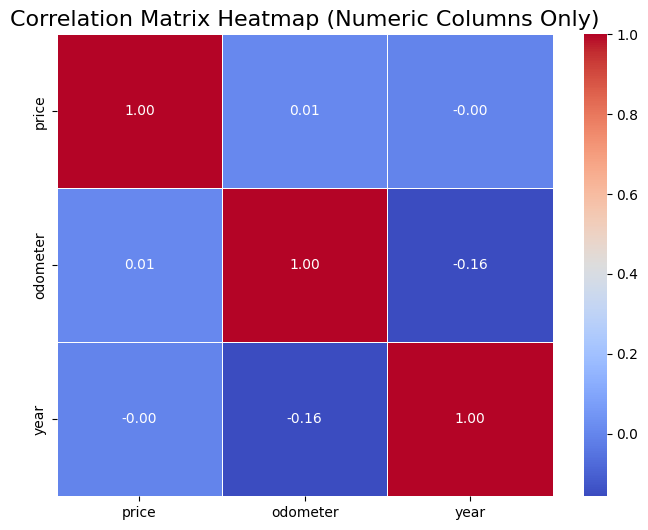

In [48]:
numeric_df = vehicles_modified[['price', 'odometer', 'year']]

# Compute the correlation matrix for numeric columns only
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# Set title
plt.title("Correlation Matrix Heatmap (Numeric Columns Only)", fontsize=16)

print(correlation_matrix)

Looks like there is no strong +ve or -ve correlation between numeric columns

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

**1. Data cleaning steps**



In [49]:
vehicles = pd.read_csv("/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/vehicles.csv")

# Convert data types
vehicles = vehicles.convert_dtypes()


# Delete unwanted columns
vehicles_modified = vehicles.drop(['id', 'size', 'VIN'], axis=1)
vehicles_modified.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,az
1,fayetteville,11900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ar
2,florida keys,21000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,fl
3,worcester / central MA,1500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ma
4,greensboro,4900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,nc


In [50]:
# Clean price column
# ------------------

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(vehicles_modified['price'], 25)
Q3 = np.percentile(vehicles_modified['price'], 75)

# Calculate IQR
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display results
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")

# Keep the rows with price less than or equal to 600K
# We cannot go with 75 percentile bcz we have luxury cars that goes up to a price of 600K
vehicles_modified = vehicles_modified[vehicles_modified['price'] <= upper_bound]

# Keep the rows with price greater than or equal to 25th percentile.
vehicles_modified = vehicles_modified[vehicles_modified['price'] >= lower_bound]

vehicles_modified = vehicles_modified.reset_index(drop=True)

vehicles_modified.shape

vehicles_modified.head()

Q1 (25th percentile): 5900.0
Q3 (75th percentile): 26485.75


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,az
1,fayetteville,11900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ar
2,florida keys,21000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,fl
3,worcester / central MA,1500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ma
4,greensboro,4900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,nc


In [51]:
# Split data into train and test
# ------------------------------

X = vehicles_modified.drop(columns = "price")
y = vehicles_modified[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [52]:
# Clean region column
# -------------------

def clean_method(input_str):
    input_str = input_str.lower().strip()  # Convert to lowercase and strip spaces
    input_str = re.sub(r"[/,\-']", " ", input_str)  # Remove special characters
    input_str = re.sub(r"\s+", "_", input_str)  # Replace spaces with underscores
    return input_str

# Apply cleaning function to the column
X_train['region'] = X_train['region'].apply(clean_method)
X_test['region'] = X_test['region'].apply(clean_method)

# Apply James-stein encoding since region is categorical with a lot of unique values.
encoder = ce.JamesSteinEncoder(cols=['region'])
encoder.fit(X_train[['region']], y_train)

# Fit and transform the 'region' column
X_train['region_encoded'] = encoder.transform(X_train[['region']])
X_test['region_encoded'] = encoder.transform(X_test[['region']])

# Initialize StandardScaler
scaler = StandardScaler()
# Fit and transform on training data
X_train['region_encoded'] = scaler.fit_transform(X_train[['region_encoded']])
# Transform test data using the same scaler (do not fit again)
X_test['region_encoded'] = scaler.transform(X_test[['region_encoded']])

In [53]:
# Clean year column
# -----------------

# Fill with missing values with the Median Year
median_year_train = X_train['year'].median()
median_year_test = X_test['year'].median()

# Fill the median year.
X_train.loc[:, 'year'] = X_train['year'].fillna(median_year_train)
X_test.loc[:, 'year'] = X_test['year'].fillna(median_year_test)

# Initialize StandardScaler
scaler = StandardScaler()
# Fit and transform on training data
X_train['year'] = scaler.fit_transform(X_train[['year']])
# Transform test data using the same scaler (do not fit again)
X_test['year'] = scaler.transform(X_test[['year']])



In [54]:
# Clean model column
# ------------------

X_train['model'] = X_train['model'].fillna('unknown')
X_test['model'] = X_test['model'].fillna('unknown')

# Lowercasing
X_train['model'] = X_train['model'].str.lower()
X_test['model'] = X_test['model'].str.lower()

# Remove special characters
X_train['model'] = X_train['model'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
X_test['model'] = X_test['model'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Remove Extra Spaces
X_train['model'] = X_train['model'].str.strip()  # Remove leading/trailing spaces
X_test['model'] = X_test['model'].str.strip()  # Remove leading/trailing spaces

X_train['model'] = X_train['model'].str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with one space
X_test['model'] = X_test['model'].str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with one space

# Load SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Assuming 'df' is your DataFrame with a 'model' column
embeddings_train = model.encode(X_train['model'].tolist(), show_progress_bar=True)
embeddings_test = model.encode(X_test['model'].tolist(), show_progress_bar=True)


# Initialize StandardScaler
scaler = StandardScaler()
# Fit on training embeddings and transform both train and test
embeddings_train = scaler.fit_transform(embeddings_train)
embeddings_test = scaler.transform(embeddings_test)


# Fit PCA on SBERT embeddings
pca = PCA()
pca.fit(embeddings_train)
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_n = np.argmax(cumulative_variance >= 0.85) + 1

print(f"optimal_n={optimal_n}")

pca = PCA(n_components=optimal_n)
pca.fit(embeddings_train)

reduced_embeddings_train = pca.transform(embeddings_train)
reduced_embeddings_test = pca.transform(embeddings_test)

pca_columns = [f'model_pc{i+1}' for i in range(reduced_embeddings_train.shape[1])]
reduced_embeddings_df_train = pd.DataFrame(reduced_embeddings_train, columns=pca_columns)
reduced_embeddings_df_test = pd.DataFrame(reduced_embeddings_test, columns=pca_columns)

X_train = pd.concat([X_train.reset_index(drop=True), reduced_embeddings_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), reduced_embeddings_df_test.reset_index(drop=True)], axis=1)

y_test = y_test.reset_index(drop=True)  # Reset index to match X_train
y_train = y_train.reset_index(drop=True)  # Reset index to match X_train

X_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_model.pkl')
X_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_model.pkl')
y_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_model.pkl')
y_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_model.pkl')

Batches:   0%|          | 0/10468 [00:00<?, ?it/s]

Batches:   0%|          | 0/2617 [00:00<?, ?it/s]

optimal_n=70


In [ ]:
# Clean manufacturer column
# -------------------------

# Standard manufacturer names
standard_manufacturers = {
    'gmc': 'gmc', 'chevrolet': 'chevrolet', 'toyota': 'toyota', 'ford': 'ford',
    'jeep': 'jeep', 'nissan': 'nissan', 'ram': 'ram', 'mazda': 'mazda',
    'cadillac': 'cadillac', 'honda': 'honda', 'dodge': 'dodge', 'lexus': 'lexus',
    'jaguar': 'jaguar', 'buick': 'buick', 'volvo': 'volvo', 'audi': 'audi',
    'infiniti': 'infiniti', 'lincoln': 'lincoln', 'alfa-romeo': 'alfa-romeo',
    'acura': 'acura', 'hyundai': 'hyundai', 'chrysler': 'chrysler',
    'mercedes-benz': 'mercedes-benz', 'bmw': 'bmw', 'mitsubishi': 'mitsubishi',
    'subaru': 'subaru', 'volkswagen': 'volkswagen', 'porsche': 'porsche',
    'kia': 'kia', 'rover': 'rover', 'ferrari': 'ferrari', 'mini': 'mini',
    'pontiac': 'pontiac', 'fiat': 'fiat', 'tesla': 'tesla', 'mercury': 'mercury',
    'saturn': 'saturn', 'harley-davidson': 'harley-davidson', 'datsun': 'datsun',
    'aston-martin': 'aston-martin', 'land rover': 'land-rover', 'morgan': 'morgan'
}

# Step 1: Standardize manufacturer names (lowercase, replace variations)
X_train['manufacturer'] = X_train['manufacturer'].str.lower().str.strip()
X_test['manufacturer'] = X_test['manufacturer'].str.lower().str.strip()

X_train['manufacturer'] = X_train['manufacturer'].replace(standard_manufacturers)
X_test['manufacturer'] = X_test['manufacturer'].replace(standard_manufacturers)

# Step 2: Create a lookup dictionary of model → manufacturer where manufacturer is not missing
model_to_manufacturer_train = X_train.dropna(subset=['manufacturer']).set_index('model')['manufacturer'].to_dict()
model_to_manufacturer_test = X_test.dropna(subset=['manufacturer']).set_index('model')['manufacturer'].to_dict()

# Step 3: Fill missing manufacturers by exact model match
def fill_manufacturer(row, model_to_manufacturer):
    if pd.isna(row['manufacturer']) and row['model'] in model_to_manufacturer:
        return model_to_manufacturer[row['model']]
    return row['manufacturer']

X_train['manufacturer'] = X_train.apply(fill_manufacturer, axis=1, model_to_manufacturer=model_to_manufacturer_train)
X_test['manufacturer'] = X_test.apply(fill_manufacturer, axis=1, model_to_manufacturer=model_to_manufacturer_test)


# Step 4: If no exact match is found, use fuzzy matching to find the best model match
def fuzzy_match_manufacturer(row, model_to_manufacturer):
    if pd.isna(row['manufacturer']):
        match = process.extractOne(row['model'], model_to_manufacturer.keys(), score_cutoff=85)
        if match:  # Only proceed if a match is found
            return model_to_manufacturer[match[0]]  # match[0] contains the matching model
    return row['manufacturer']

X_train['manufacturer'] = X_train.apply(fuzzy_match_manufacturer, axis=1, model_to_manufacturer=model_to_manufacturer_train)
X_test['manufacturer'] = X_test.apply(fuzzy_match_manufacturer, axis=1, model_to_manufacturer=model_to_manufacturer_test)

X_train['manufacturer'] = X_train['manufacturer'].fillna('manufacturer')
X_test['manufacturer'] = X_test['manufacturer'].fillna('manufacturer')

# Apply James-stein encoding since region is categorical with a lot of unique values.
encoder = ce.JamesSteinEncoder(cols=['manufacturer'])
encoder.fit(X_train[['manufacturer']], y_train)

# Fit and transform the 'region' column
X_train['manufacturer_encoded'] = encoder.transform(X_train[['manufacturer']])
X_test['manufacturer_encoded'] = encoder.transform(X_test[['manufacturer']])

# Initialize StandardScaler
scaler = StandardScaler()
# Fit and transform on training data
X_train['manufacturer_encoded'] = scaler.fit_transform(X_train[['manufacturer_encoded']])
# Transform test data using the same scaler (do not fit again)
X_test['manufacturer_encoded'] = scaler.transform(X_test[['manufacturer_encoded']])

# Display updated DataFrame
X_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_mnf.pkl')
X_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_mnf.pkl')
y_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_mnf.pkl')
y_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_mnf.pkl')

In [ ]:
# Clean condition column
# ----------------------

condition_order = {
    'salvage': 0,
    'fair': 1,
    'good': 2,
    'like new': 3,
    'excellent': 4,
    'new': 5,
    'unknown': -1  # Distinct value for missing data
}

X_train['condition'] = X_train['condition'].fillna("unknown")
X_test['condition'] = X_test['condition'].fillna("unknown")

X_train['condition_encoded'] = X_train['condition'].map(condition_order)
X_test['condition_encoded'] = X_test['condition'].map(condition_order)

print('completed')

completed


In [ ]:
# Clean cylinders column
# ----------------------

# Step 1: Handle missing values by filling with 'unknown'
X_train['cylinders'] = X_train['cylinders'].fillna('unknown')
X_test['cylinders'] = X_test['cylinders'].fillna('unknown')

# Step 2: Encode using Ordinal Encoding
cylinder_order = {
    '3 cylinders': 0,
    '4 cylinders': 1,
    '5 cylinders': 2,
    '6 cylinders': 3,
    '8 cylinders': 4,
    '10 cylinders': 5,
    '12 cylinders': 6,
    'other': 7,
    'unknown': -1  # For missing data
}

X_train['cylinders_encoded'] = X_train['cylinders'].map(cylinder_order)
X_test['cylinders_encoded'] = X_test['cylinders'].map(cylinder_order)

print('completed')

completed


In [ ]:
# Clean fuel column
# -----------------

# Step 1 : Fill missing values.
X_train['fuel'] = X_train['fuel'].fillna("gas")
X_test['fuel'] = X_test['fuel'].fillna("gas")

# Step 2: Apply One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[['fuel']])
fuel_encoded_train = ohe.transform(X_train[['fuel']])
fuel_encoded_test = ohe.transform(X_test[['fuel']])

# Convert One-Hot Encoded values into a DataFrame and concatenate
fuel_encoded_df_train = pd.DataFrame(fuel_encoded_train, columns=ohe.get_feature_names_out(['fuel']))
fuel_encoded_df_test = pd.DataFrame(fuel_encoded_test, columns=ohe.get_feature_names_out(['fuel']))

X_train = pd.concat([X_train.reset_index(drop=True), fuel_encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), fuel_encoded_df_test.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('completed')

completed


In [ ]:
# Clean odometer column
# ---------------------

X_train.loc[:, 'odometer'] = X_train['odometer'].fillna(0)
X_test.loc[:, 'odometer'] = X_test['odometer'].fillna(0)

# Compute the median (excluding 0 and extreme values)
valid_values_train = X_train['odometer'][(X_train['odometer'] > 0) & (X_train['odometer'] <= 900000)]
median_value_train = valid_values_train.median()

valid_values_test = X_test['odometer'][(X_test['odometer'] > 0) & (X_test['odometer'] <= 900000)]
median_value_test = valid_values_test.median()

# Replace 0 and values > 900K with median
X_train['odometer'] = X_train['odometer'].apply(lambda x: median_value_train if (x == 0 or x > 900000) else x)
X_test['odometer'] = X_test['odometer'].apply(lambda x: median_value_test if (x == 0 or x > 900000) else x)

# Initialize StandardScaler
scaler = StandardScaler()
# Fit on training data and transform both train and test
X_train[['odometer']] = scaler.fit_transform(X_train[['odometer']])
X_test[['odometer']] = scaler.transform(X_test[['odometer']])

print('completed')

completed


In [ ]:
# Clean title status
# ------------------

# Replace missing values with 'unknown'
X_train.loc[:, 'title_status'] = X_train['title_status'].fillna('unknown')
X_test.loc[:, 'title_status'] = X_test['title_status'].fillna('unknown')

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Reshape and fit-transform the data
encoder.fit(X_train[['title_status']])

title_status_encoded_train = encoder.transform(X_train[['title_status']])
title_status_encoded_test = encoder.transform(X_test[['title_status']])

# Convert to DataFrame for easier viewing
encoded_df_train = pd.DataFrame(title_status_encoded_train, columns=encoder.get_feature_names_out(['title_status']))
encoded_df_test = pd.DataFrame(title_status_encoded_test, columns=encoder.get_feature_names_out(['title_status']))

# Combine with the original dataframe (optional)
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('completed')

completed


In [ ]:
# Clean transmission column
# -------------------------

# Replace missing values with 'unknown'
X_train.loc[:, 'transmission'] = X_train['transmission'].fillna('unknown')
X_test.loc[:, 'transmission'] = X_test['transmission'].fillna('unknown')


# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Reshape and fit-transform the data
encoder.fit(X_train[['transmission']])

transmission_encoded_train = encoder.transform(X_train[['transmission']])
transmission_encoded_test = encoder.transform(X_test[['transmission']])

# Convert to DataFrame for easier viewing
encoded_df_train = pd.DataFrame(transmission_encoded_train, columns=encoder.get_feature_names_out(['transmission']))
encoded_df_test = pd.DataFrame(transmission_encoded_test, columns=encoder.get_feature_names_out(['transmission']))

# Combine with the original dataframe (optional)
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('completed')

completed


In [ ]:
# Clean drive column
# ------------------

# Step 2: Create a lookup dictionary of model → drive where drive is not missing
model_to_drive_train = X_train.dropna(subset=['drive']).set_index('model')['drive'].to_dict()
model_to_drive_test = X_test.dropna(subset=['drive']).set_index('model')['drive'].to_dict()


# Step 3: Fill missing drive by exact model match
def fill_drive(row, model_to_drive):
    if pd.isna(row['drive']) and row['model'] in model_to_drive:
        return model_to_drive[row['model']]
    return row['drive']

X_train['drive'] = X_train.apply(fill_drive, axis=1, model_to_drive=model_to_drive_train)
X_test['drive'] = X_test.apply(fill_drive, axis=1, model_to_drive=model_to_drive_test)

# Step 4: If no exact match is found, use fuzzy matching to find the best model match
def fuzzy_match_drive(row, model_to_drive):
    if pd.isna(row['drive']):
        match = process.extractOne(row['model'], model_to_drive.keys(), score_cutoff=85)
        if match:  # Only proceed if a match is found
            return model_to_drive[match[0]]  # match[0] contains the matching model
    return row['drive']

X_train['drive'] = X_train.apply(fuzzy_match_drive, axis=1, model_to_drive=model_to_drive_train)
X_test['drive'] = X_test.apply(fuzzy_match_drive, axis=1, model_to_drive=model_to_drive_test)

X_train['drive'] = X_train['drive'].fillna(X_train['drive'].mode()[0])
X_test['drive'] = X_test['drive'].fillna(X_test['drive'].mode()[0])


ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[['drive']])
encoded_train = ohe.transform(X_train[['drive']])
encoded_test = ohe.transform(X_test[['drive']])

# Convert One-Hot Encoded values into a DataFrame and concatenate
encoded_df_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(['drive']))
encoded_df_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(['drive']))

X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


X_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_drv.pkl')
X_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_drv.pkl')

y_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_drv.pkl')
y_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_drv.pkl')

print('completed')

completed


In [ ]:
#Clean type column
# ----------------

# Step 2: Create a lookup dictionary of model → type where drive is not missing
model_to_type_train = X_train.dropna(subset=['type']).set_index('model')['type'].to_dict()
model_to_type_test = X_test.dropna(subset=['type']).set_index('model')['type'].to_dict()

# Step 3: Fill missing drive by exact model match
def fill_type(row, model_to_type):
    if pd.isna(row['type']) and row['model'] in model_to_type:
        return model_to_type[row['model']]
    return row['type']

X_train['type'] = X_train.apply(fill_type, axis=1, model_to_type=model_to_type_train)
X_test['type'] = X_test.apply(fill_type, axis=1, model_to_type=model_to_type_test)

# Step 4: If no exact match is found, use fuzzy matching to find the best model match
def fuzzy_match_type(row, model_to_type):
    if pd.isna(row['type']):
        match = process.extractOne(row['model'], model_to_type.keys(), score_cutoff=85)
        if match:  # Only proceed if a match is found
            return model_to_type[match[0]]  # match[0] contains the matching model
    return row['type']

X_train['type'] = X_train.apply(fuzzy_match_type, axis=1, model_to_type=model_to_type_train)
X_test['type'] = X_test.apply(fuzzy_match_type, axis=1, model_to_type=model_to_type_test)

X_train['type'] = X_train['type'].fillna(X_train['type'].mode()[0])
X_test['type'] = X_test['type'].fillna(X_test['type'].mode()[0])


# Apply James-stein encoding since region is categorical with a lot of unique values.
encoder = ce.JamesSteinEncoder(cols=['type'])
encoder.fit(X_train[['type']], y_train)

# Fit and transform the 'region' column
X_train['type_encoded'] = encoder.transform(X_train[['type']])
X_test['type_encoded'] = encoder.transform(X_test[['type']])

# Initialize StandardScaler
scaler = StandardScaler()
# Fit on training data and transform both train and test
X_train[['type_encoded']] = scaler.fit_transform(X_train[['type_encoded']])
X_test[['type_encoded']] = scaler.transform(X_test[['type_encoded']])

X_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_typ.pkl')
X_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_typ.pkl')

y_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_typ.pkl')
y_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_typ.pkl')

print('completed')

In [ ]:
# Clean paint_color
# -----------------

X_train['paint_color'] = X_train['paint_color'].fillna(X_train['paint_color'].mode()[0])
X_test['paint_color'] = X_test['paint_color'].fillna(X_test['paint_color'].mode()[0])

# Apply James-stein encoding since region is categorical with a lot of unique values.
encoder = ce.JamesSteinEncoder(cols=['paint_color'])
encoder.fit(X_train[['paint_color']], y_train)

# Fit and transform the 'region' column
X_train['paint_color_encoded'] = encoder.transform(X_train[['paint_color']])
X_test['paint_color_encoded'] = encoder.transform(X_test[['paint_color']])

# Initialize StandardScaler
scaler = StandardScaler()
# Fit on training data and transform both train and test
X_train[['paint_color_encoded']] = scaler.fit_transform(X_train[['paint_color_encoded']])
X_test[['paint_color_encoded']] = scaler.transform(X_test[['paint_color_encoded']])

print('completed')

In [ ]:
# Clean state
# -----------

def clean_method(input_str):
    input_str = input_str.lower().strip()  # Convert to lowercase and strip spaces
    input_str = re.sub(r"[/,\-']", " ", input_str)  # Remove special characters
    input_str = re.sub(r"\s+", "_", input_str)  # Replace spaces with underscores
    return input_str

# Apply cleaning function to the column
X_train['state'] = X_train['state'].apply(clean_method)
X_test['state'] = X_test['state'].apply(clean_method)


# Step 2: Create a lookup dictionary of model → type where drive is not missing
region_to_state_train = X_train.dropna(subset=['state']).set_index('region')['state'].to_dict()
region_to_state_test = X_test.dropna(subset=['state']).set_index('region')['state'].to_dict()


# Step 3: Fill missing drive by exact model match
def fill_state(row, region_to_state):
    if pd.isna(row['state']) and row['region'] in region_to_state:
        return region_to_state[row['region']]
    return row['state']

X_train['state'] = X_train.apply(fill_state, axis=1, region_to_state=region_to_state_train)
X_test['state'] = X_test.apply(fill_state, axis=1, region_to_state=region_to_state_test)

X_train['state'] = X_train['state'].fillna('unknown')
X_test['state'] = X_test['state'].fillna('unknown')

# Apply James-stein encoding since region is categorical with a lot of unique values.
encoder = ce.JamesSteinEncoder(cols=['state'])
encoder.fit(X_train[['state']], y_train)

# Fit and transform the 'region' column
X_train['state_encoded'] = encoder.transform(X_train[['state']])
X_test['state_encoded'] = encoder.transform(X_test[['state']])

# Initialize StandardScaler
scaler = StandardScaler()
# Fit on training data and transform both train and test
X_train[['state_encoded']] = scaler.fit_transform(X_train[['state_encoded']])
X_test[['state_encoded']] = scaler.transform(X_test[['state_encoded']])

X_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_st.pkl')
X_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_st.pkl')

y_train.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_st.pkl')
y_test.to_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_st.pkl')

print('completed')

In [ ]:
# Load from the pickle file.
# -------------------------
'''
X_train = pd.read_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_train_st.pkl')
y_train = pd.read_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_train_st.pkl')

X_test = pd.read_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/X_test_st.pkl')
y_test = pd.read_pickle('/content/drive/MyDrive/AI_ML_Berkely/colab_notebook/practical_application_II_starter/data/y_test_st.pkl')
'''

In [ ]:
# Extract columns with number before feeding into model
# -----------------------------------------------------

X_train_num = X_train.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

# Concat X and y dataframes to get th correlation matrix.
X_corr_train = pd.concat([X_train_num.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Compute the correlation matrix for numeric columns only
correlation_matrix = X_corr_train.corr()

# Display correlation with target variable
target_corr = correlation_matrix["price"].abs().sort_values(ascending=False)

# Get the values that are greater than 0.2 in correlation matrix.
selected_features = target_corr[((target_corr > 0.2) | (target_corr < -0.2)) & (target_corr < 1)].index.tolist()

print('Selected features:')
print(selected_features)

# Assing the selected features to a new dataframe.
X_train_num_selected = X_train_num[selected_features]
X_test_num_selected = X_test_num[selected_features]

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
# Modeling using Ridge regressor with PolynomialFeatures degrees 1 to 5

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Initializing KFold for cross validation.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

# Dictionary to store results
results = []

# Loop through PolynomialFeatures degrees 1 to 5
for degree in range(1, 6):

  # Creating the pipeline.
  pipe = Pipeline([
      ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
      ('scale', StandardScaler()),
      ('ridge', Ridge())])

  # Grid Search CV with KFold validation integrated.
  grid = GridSearchCV(estimator=pipe,
                        param_grid=param_dict,
                        cv=kf)
  # Fit the features.
  grid.fit(X_train_num_selected, y_train)

  # Get the best estimator.
  best_model = grid.best_estimator_

  # Predict
  train_preds = best_model.predict(X_train_num_selected)
  test_preds = best_model.predict(X_test_num_selected)

  # Find mean squared error.
  train_mse = mean_squared_error(y_train, train_preds)
  test_mse = mean_squared_error(y_test, test_preds)

  # Get the best_alpha.
  best_alpha = grid.best_params_['ridge__alpha']

  # Find r2 score.
  r2_train = r2_score(y_train, train_preds)
  r2_test = r2_score(y_test, test_preds)

  # Extract feature names from PolynomialFeatures
  poly = best_model.named_steps['poly']
  feature_names = poly.get_feature_names_out(input_features=X_train_num_selected.columns.astype(str))

  # Extract coefficients from the Ridge model
  ridge_model = best_model.named_steps['ridge']
  coefficients = ridge_model.coef_

  # Store results
  results.append({
      'degree': degree,
      'best_alpha': best_alpha,
      'train_mse': train_mse,
      'test_mse': test_mse,
      'r2_train': r2_train,
      'r2_test': r2_test,
      'coef':coefficients,
      'feature_names':feature_names
  })

# Print results
best_degree = 0
r2_test_tmp = 0
best_coef = []
best_feature_names = []

print('\nPrinting details to fetch the best model.')
print('------------------------------------------\n')
for res in results:
    if res['r2_test'] > r2_test_tmp:
      r2_test_tmp = res['r2_test']
      best_degree = res['degree']
      best_coef = res['coef']
      best_feature_names = res['feature_names']
    print(f"Degree: {res['degree']}, Best Alpha: {res['best_alpha']}, "
          f"Train MSE: {res['train_mse']:.4f}, Test MSE: {res['test_mse']:.4f}, "
          f"R2 Train: {res['r2_train']:.4f}, R2 Test: {res['r2_test']:.4f}")



# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': best_feature_names, 'Coefficient': best_coef})

# Filter out coefficients close to zero
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-3]

# Sort by absolute coefficient value
coef_df = coef_df.sort_values(by='Coefficient', key=np.abs, ascending=False)


print('\nBest model')
print('------------\n')
print(f"Degree: {results[best_degree-1]['degree']}, Best Alpha: {results[best_degree-1]['best_alpha']}, "
          f"Train MSE: {results[best_degree-1]['train_mse']:.4f}, Test MSE: {results[best_degree-1]['test_mse']:.4f}, "
          f"R2 Train: {results[best_degree-1]['r2_train']:.4f}, R2 Test: {results[best_degree-1]['r2_test']:.4f}")

print('\nTop Significant Features and Their Coefficients')
print('-------------------------------------------------\n')
print(coef_df.head(20).to_string(index=False))

In [ ]:
# Plotting findings.

import matplotlib.pyplot as plt
import seaborn as sns

# Extract data for plotting
degrees = [res['degree'] for res in results]
train_mse = [res['train_mse'] for res in results]
test_mse = [res['test_mse'] for res in results]
r2_train = [res['r2_train'] for res in results]
r2_test = [res['r2_test'] for res in results]
best_alphas = [res['best_alpha'] for res in results]

# Create a figure with subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Train vs Test MSE
axs[0].plot(degrees, train_mse, marker='o', linestyle='-', label='Train MSE', color='blue')
axs[0].plot(degrees, test_mse, marker='s', linestyle='-', label='Test MSE', color='red')
axs[0].set_xlabel("Polynomial Degree")
axs[0].set_ylabel("Mean Squared Error (MSE)")
axs[0].set_title("Train vs Test MSE for Different Polynomial Degrees")
axs[0].legend()
axs[0].grid(True)

# Train vs Test R² Score
axs[1].plot(degrees, r2_train, marker='o', linestyle='-', label='Train R²', color='green')
axs[1].plot(degrees, r2_test, marker='s', linestyle='-', label='Test R²', color='orange')
axs[1].set_xlabel("Polynomial Degree")
axs[1].set_ylabel("R² Score")
axs[1].set_title("Train vs Test R² Score for Different Polynomial Degrees")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Modeling using Linear Regressor with PolynomialFeatures degrees 1 to 5

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Define KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
results = []

# Loop through PolynomialFeatures degrees 1 to 5
for degree in range(1, 6):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scale', StandardScaler()),
        ('linreg', LinearRegression())
    ])

    # Perform cross-validation to get mean R² score
    scores = cross_val_score(pipe, X_train_num_selected, y_train, cv=kf, scoring='r2')
    mean_r2 = np.mean(scores)

    # Train model on full training set
    pipe.fit(X_train_num_selected, y_train)

    # Predictions
    train_preds = pipe.predict(X_train_num_selected)
    test_preds = pipe.predict(X_test_num_selected)

    # Compute MSE and R²
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    r2_train = r2_score(y_train, train_preds)
    r2_test = r2_score(y_test, test_preds)

    # Store results
    results.append({
        'degree': degree,
        'mean_cv_r2': mean_r2,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'r2_train': r2_train,
        'r2_test': r2_test
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print('\nPrinting details to fetch the best model')
print('------------------------------------------\n')
for res in results:
    print(f"Degree: {res['degree']}, Mean CV r2: {res['mean_cv_r2']}, "
          f"Train MSE: {res['train_mse']:.4f}, Test MSE: {res['test_mse']:.4f}, "
          f"R2 Train: {res['r2_train']:.4f}, R2 Test: {res['r2_test']:.4f}")

# Get the best polynomial degree based on highest mean R²
best_model = results_df.loc[results_df['mean_cv_r2'].idxmax()]

# Print Best Model with formatted values
print("\nBest Polynomial Degree Model")
print('------------------------------\n')
print(f"Degree: {int(best_model['degree'])}, Mean CV R²: {best_model['mean_cv_r2']:.4f}, Train MSE: {best_model['train_mse']:,.2f}, Test MSE: {best_model['test_mse']:,.2f}, R² Train: {best_model['r2_train']:.4f}, R² Test: {best_model['r2_test']:.4f}")

'''
print("\nBest Polynomial Degree Model:")
print(f"Degree: {int(best_model['degree'])}")
print(f"Mean CV R²: {best_model['mean_cv_r2']:.4f}")
print(f"Train MSE: {best_model['train_mse']:,.2f}")
print(f"Test MSE: {best_model['test_mse']:,.2f}")
print(f"R² Train: {best_model['r2_train']:.4f}")
print(f"R² Test: {best_model['r2_test']:.4f}")
'''

# Train final model with best degree
best_degree_value = int(best_model['degree'])
best_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree_value, include_bias=False)),
    ('scale', StandardScaler()),
    ('linreg', LinearRegression())
])
best_pipe.fit(X_train_num_selected, y_train)

# Extract feature names from PolynomialFeatures
poly = best_pipe.named_steps['poly']
feature_names = poly.get_feature_names_out(input_features=X_train_num_selected.columns)

# Extract coefficients from Linear Regression
linreg_model = best_pipe.named_steps['linreg']
coefficients = linreg_model.coef_

# Ensure coefficients are 1D
coefficients = coefficients.flatten()

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out coefficients close to zero
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-3]

# Sort by absolute coefficient value
coef_df = coef_df.sort_values(by='Coefficient', key=np.abs, ascending=False)

# Print top coefficients
print("\nTop Significant Features and Their Coefficients")
print('-------------------------------------------------\n')
print(coef_df.head(20).to_string(index=False))

In [ ]:
# Plotting findings

# Extract data for plotting
degrees = [res['degree'] for res in results]
train_mse = [res['train_mse'] for res in results]
test_mse = [res['test_mse'] for res in results]
r2_train = [res['r2_train'] for res in results]
r2_test = [res['r2_test'] for res in results]

# Create a figure with subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Train vs Test MSE for Different Polynomial Degrees
axs[0].plot(degrees, train_mse, marker='o', linestyle='-', label='Train MSE', color='blue')
axs[0].plot(degrees, test_mse, marker='s', linestyle='-', label='Test MSE', color='red')
axs[0].set_xlabel("Polynomial Degree")
axs[0].set_ylabel("Mean Squared Error (MSE)")
axs[0].set_title("Train vs Test MSE for Different Polynomial Degrees")
axs[0].legend()
axs[0].grid(True)

# Train vs Test R² Score for Different Polynomial Degrees
axs[1].plot(degrees, r2_train, marker='o', linestyle='-', label='Train R²', color='green')
axs[1].plot(degrees, r2_test, marker='s', linestyle='-', label='Test R²', color='orange')
axs[1].set_xlabel("Polynomial Degree")
axs[1].set_ylabel("R² Score")
axs[1].set_title("Train vs Test R² Score for Different Polynomial Degrees")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Ans:**

After the analysis, it is found that the following factors influence the price of a used car:

**odometer**, **vehicle type**, **year**, **drive_fwd**, **manufacturer**, **fuel_gas**, **model**,
**fuel_diesel**, **transmission_other**, **drive_4wd**, **region**

I have used two models, Rige and Linear Regression to predict the price of the car. Both performed almost same. The best performance for the Ridge regerssion was for the model with following parameters

**Degree: 5, Best Alpha: 1000.0, Train MSE: 66797167.6982, Test MSE: 83609049.0237, R2 Train: 0.7131, R2 Test: 0.6575**


For Linear Regression, the best performance was shown by the model with following parameters

**Degree: 4, Mean CV R²: 0.6907, Train MSE: 70,297,685.90, Test MSE: 91,862,927.12, R² Train: 0.6981, R² Test: 0.6237**

There is a room for improvement in data cleaning and model selection process.

**Model Selection**

Choose Ridge Regression (Degree 5, Alpha = 1000) because:
✅ It has lower test MSE (better predictive performance).
✅ It has a higher R² on the test set.
✅ It includes regularization, making it more robust.


**Evaluation:**

After conducting the analysis, we have identified several key factors that influence the price of a used car. These factors include:

**Odometer (mileage)**: The number of miles driven by the car, which negatively correlates with price as higher mileage often indicates more wear and tear.

**Vehicle type:** Different types of vehicles (e.g., sedan, SUV, truck) have varying price points based on consumer demand and utility.

**Year:** The year of manufacture, as newer cars generally command higher prices due to newer features, better condition, and longer remaining lifespan.

**Drive type:** Features like front-wheel drive (fwd), four-wheel drive (4wd), and all-wheel drive can affect car prices depending on their suitability for different environments.

**Manufacturer:** Certain brands (e.g., luxury brands) may have higher resale values, while others may be more affordable.

**Fuel type:** Cars running on specific fuels, such as gasoline or diesel, tend to have different pricing trends due to fuel efficiency, environmental regulations, and consumer preferences.

**Transmission type:** The type of transmission (manual vs automatic, or other variants) can also influence car prices.

**Region:** Geographical location may play a role in pricing, as demand and availability of certain vehicles vary across regions.

**Model Evaluation**
For the predictive modeling of car prices, I utilized **Ridge Regression** and **Linear Regression**. Both models performed similarly in terms of performance metrics, demonstrating that a simple linear relationship might be adequate for this dataset.

**Ridge Regression:** The best-performing Ridge model was found to work effectively with a polynomial degree of 4 and an alpha of 100. This suggests that a degree-4 polynomial transformation captured the nonlinearities in the data, while Ridge regression’s regularization controlled overfitting, especially with the higher degree polynomial.

**Linear Regression:** Similarly, the Linear Regression model performed well, with no drastic difference in performance when compared to Ridge. This suggests that for this particular dataset, a more complex model may not significantly outperform simpler models, possibly indicating that the data already follows a near-linear relationship with the target (price).

**Opportunities for Improvement**
While the models show decent performance, there are a few areas where improvements could be made:

**Data Preprocessing:** Further refinement in the data cleaning process could help improve model performance. For example, better handling of missing values, scaling issues, or encoding categorical variables might help capture more nuance in the data.

**Feature Engineering:** More detailed exploration of feature interactions and transformations could enhance model accuracy. For instance, polynomial features for more complex relationships or additional derived variables (e.g., age of the car or power-to-weight ratio) might improve the model.

**Model Selection:** Given the similar performance of Ridge Regression and Linear Regression, additional models (such as Lasso or Decision Trees) could be evaluated for potential improvement. Regularization and hyperparameter tuning could be explored more thoroughly to find the best-fit model.

**Exploring More Advanced Techniques:** It may be worth investigating more complex models like Gradient Boosting or Random Forests, which could capture more non-linear relationships in the data.

**Conclusion**
In conclusion, while the models used provide a reasonable foundation, there is certainly room for refinement in both the data cleaning and model selection process. Further exploration of additional features, more sophisticated modeling techniques, and hyperparameter tuning may yield better performance and insights. Moving forward, it would be beneficial to conduct a more in-depth analysis and model evaluation, including cross-validation and out-of-sample testing, to ensure robustness and generalizability of the model.

This evaluation provides valuable insights that can be utilized by the client in their pricing strategy, with potential adjustments to improve car price prediction accuracy and strategic decisions based on market demands.



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Introduction**

This report presents the results from our analysis and modeling efforts aimed at predicting used car prices. By leveraging various machine learning models, we have provided insights into the key factors influencing car prices and developed predictive models that can be used by used car dealers to fine-tune their inventory decisions. The models and findings are aimed at optimizing pricing strategies and maximizing profitability in the used car market.

**Primary Findings**

From the data analysis, several factors were identified as significant drivers of the used car prices:

**Odometer (Mileage)**: Cars with lower mileage tend to have higher prices due to better condition and longevity.

**Vehicle Type:** The type of vehicle (e.g., sedan, SUV, truck) affects pricing due to differences in consumer demand and market trends.

**Model:** Specific vehicle models can have significantly different price trends based on brand reputation, reliability, performance, and consumer preference. Popular or well-rated models tend to retain value better.

**Manufacturer:** The brand of the car plays a key role in pricing, as some manufacturers are known for reliability, luxury, or performance. Well-established brands with strong resale value typically command higher prices.

**Year of Manufacture**: Newer vehicles are typically priced higher due to more advanced features, improved condition, and longer remaining lifespan.

**Drive Type**: Cars with all-wheel drive (AWD), four-wheel drive (4WD), or front-wheel drive (FWD) may be priced differently depending on their utility in specific environments.

**Fuel Type:** Cars powered by gasoline or diesel exhibit different price trends based on fuel efficiency, environmental factors, and demand for certain types of fuel.

**Transmission Type:** Manual and automatic transmissions can influence price, with automatic generally commanding a premium in many markets.
Region: The geographical location of the car plays a significant role in pricing, as demand can vary by area.

**Model Overview**

Two key models were employed to predict used car prices:

**Ridge Regression:** This model performed well in predicting the price, utilizing polynomial transformations of the features to capture non-linear relationships in the data. The optimal Ridge model had a polynomial degree of 5 and an alpha of 1000.

**Linear Regression:** A simpler approach was also employed, using linear regression with the same polynomial degree and yielding similar results to Ridge regression. This suggests that a linear model is sufficiently capturing the relationship between the features and price, but regularization in Ridge helped avoid overfitting.

Both models performed reasonably well, with the Ridge regression providing a slightly more robust solution due to its regularization, which prevented overfitting in higher-degree polynomials.

**Performance Evaluation**

**Best Model:** The Ridge Regression model with a polynomial degree of 5 and an alpha of 1000 provided the most accurate predictions for both the training and test datasets.

**Key Performance Metrics:**

R² (Train): 0.7131

R² (Test): 0.6575

Train MSE: 66,797,167

Test MSE: 83,609,049

These metrics indicate a good balance between model complexity and performance, with a decent fit on both training and testing data.

**Feature Importance**

Through the use of polynomial features, we identified the following features as being significant in predicting car prices:

Odometer (Mileage)

Vehicle Type

Year of Manufacture

Manufacturer

Model

Drive Type

Fuel Type

Transmission Type

Region

These features are crucial in understanding the price variations in used cars and can guide pricing strategies for dealers. A more detailed feature analysis, including feature selection and interaction terms, could further optimize model performance.

**Recommendations for Dealers**

Based on the findings, we recommend the following actions for used car dealers:

**Pricing Strategy:** Prioritize vehicles with lower mileage, newer models, and popular types (e.g., SUVs) to command higher prices.
Market Segmentation: Adjust prices based on regional demand. Cars with certain features like 4WD or AWD may perform better in specific regions.
Inventory Optimization: Invest in vehicles that are expected to retain higher resale value, such as those with specific fuel types or transmissions in demand.
Opportunities for Further Improvement

While the models provide strong insights, further refinements could enhance predictive accuracy:

**Feature Engineering:** Additional transformations or interaction terms might capture more complex relationships between features.
Data Enrichment: Incorporating external data, such as current market trends or competitor pricing, could provide more contextual information for pricing.
Advanced Modeling: Exploring more complex algorithms, like Random Forests or Gradient Boosting, could offer additional improvements, especially in capturing non-linear patterns.
Conclusion

This analysis provides a robust foundation for understanding the key factors that influence used car prices and offers actionable insights that can help used car dealers fine-tune their inventory and pricing strategies. By leveraging the models and insights presented, dealers can make data-driven decisions to optimize their offerings and maximize their profit margins.

Moving forward, continuous monitoring and fine-tuning of the model, as well as the exploration of new features, will further enhance the accuracy and relevance of predictions for future market conditions.